In [1]:
import wbdata
import pandas as pd
import numpy as np
import json
from openai import OpenAI
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import time
import warnings
import math
import re
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from ast import literal_eval  #Is used to safely evaluate a string that looks like a Python literal 
import logging
# Suppress OpenAI cache logs
logging.getLogger("openai._base_client").setLevel(logging.ERROR)
logging.getLogger("shelved_cache").setLevel(logging.ERROR)
logging.getLogger("shelved_cache.persistent_cache").setLevel(logging.ERROR)
logging.getLogger('shelved_cache.persistent_cache').setLevel(logging.ERROR) #Libraries warnings
warnings.filterwarnings('ignore') #Python warnings


Key '-4545488466268063596' not in persistent cache.
Key '8461470813280911568' not in persistent cache.
Key '-987649506414154508' not in persistent cache.
Key '-1240461851427200374' not in persistent cache.
Key '-3643552882487409625' not in persistent cache.
Key '8743510830346601348' not in persistent cache.
Key '-6681672228968287810' not in persistent cache.
Key '1341541027845755560' not in persistent cache.
Key '-3709221908864942388' not in persistent cache.
Key '6576134988204714056' not in persistent cache.
Key '4433109748010723682' not in persistent cache.
Key '-5016010571684342394' not in persistent cache.
Key '-6131368459689380741' not in persistent cache.
Key '-6297597031424999469' not in persistent cache.
Key '-8700688062485208720' not in persistent cache.
Key '1584668834584447724' not in persistent cache.
Key '6307530858787527469' not in persistent cache.
Key '-3141589460907538607' not in persistent cache.
Key '7143767436162117837' not in persistent cache.
Key '-902296530451194

In [2]:
import tiktoken

# Use OpenAI tokenizer to calculate token lengths (optional, more accurate)
def estimate_token_count(text, model="gpt-3.5-turbo-instruct"):
    enc = tiktoken.encoding_for_model(model)
    return len(enc.encode(text))

### Prompt to retrieve the best indicators for our analysis

In [3]:
wbdata.get_sources()

  id  name
----  --------------------------------------------------------------------
   1  Doing Business
   2  World Development Indicators
   3  Worldwide Governance Indicators
   5  Subnational Malnutrition Database
   6  International Debt Statistics
  11  Africa Development Indicators
  12  Education Statistics
  13  Enterprise Surveys
  14  Gender Statistics
  15  Global Economic Monitor
  16  Health Nutrition and Population Statistics
  18  IDA Results Measurement System
  19  Millennium Development Goals
  20  Quarterly Public Sector Debt
  22  Quarterly External Debt Statistics SDDS
  23  Quarterly External Debt Statistics GDDS
  25  Jobs
  27  Global Economic Prospects
  28  Global Financial Inclusion
  29  The Atlas of Social Protection: Indicators of Resilience and Equity
  30  Exporter Dynamics Database – Indicators at Country-Year Level
  31  Country Policy and Institutional Assessment
  32  Global Financial Development
  33  G20 Financial Inclusion Indicators
  34  Glob

In [4]:
base_prompt  = """
You are a data scientist tasked with selecting the most relevant development indicators to predict when a country will reach the GDP per capita level of developed countries.

Below is a list of available indicators retrieved from the World Bank. Each item consists of an indicator code and its corresponding name:

{chunked_indicators}

Your task:
- Select indicators that are strongly related to GDP growth, economic development, or structural transformation (e.g., education, infrastructure, industrialization, trade, institutions).
- Prioritize indicators that are leading indicators or have a causal influence on development and healh.
- Select only {number_of_indicators_per_chunk} indicators. Do not exceed this number.
- Dict_indicators must have only {number_of_indicators_per_chunk} keys
- Do not select any indicator related with CPIA

Output format:
- Return a valid Python dictionary where each key is the indicator code, and the value is a short, clean summary of the indicator's meaning.
- Clean each indicator name by removing any special characters, keeping only letters, spaces, and the '%' sign.
- Do not include code wrapping, markdown formatting, comments, or line breaks.
- Output only the dictionary in a single line, formatted like this:

dict_indicators = {{'CODE1': 'Abstract indicator name meaning 1','CODE2': 'Abstract indicator name meaning 2'}} """


Since we are going to use an LLM to retrieve the most relevant indicators and the list of available indicators is quite large, we need to create chunks to use with our LLM model without encountering any prompt size issues.

In [5]:
available_indicators = wbdata.get_indicators(source=2) #   Source 2 = World Development Indicators

df_indicators = pd.DataFrame(available_indicators)[['id','name']]

enc = tiktoken.encoding_for_model("gpt-3.5-turbo-instruct")
df_indicators["token_count"] = df_indicators["name"].apply(lambda x: len(enc.encode(x)))

base_prompt_count = estimate_token_count(base_prompt)
model_max_tokens = 2500   # Model's maximum context length is 4097 tokens
max_prompt_tokens = model_max_tokens - base_prompt_count
chunk_index = []

for i in range(1,len(df_indicators)):
    if len(chunk_index) == 0:
        list_indicators = "\n".join((df_indicators["id"][0:i] + ": " + df_indicators["name"][0:i]).tolist())
        token_count = estimate_token_count(list_indicators)
    else:
        list_indicators = "\n".join((df_indicators["id"][current_index:i] + ": " + df_indicators["name"][current_index:i]).tolist())
        token_count = estimate_token_count(list_indicators)
    if token_count>max_prompt_tokens:
        current_index = i
        chunk_index.append(i)
        token_count = 0

list_indicators = (df_indicators["id"] + ": " + df_indicators["name"]).tolist()

chunks = [
    list_indicators[0:index] if i == 0 
    else list_indicators[chunk_index[i-1]:index]
    for i, index in enumerate(chunk_index)
]


In [6]:
# Load credentials
with open("credentials.json", "r") as file:
    credentials = json.load(file)

# Initialize the client
client = OpenAI(
    api_key=credentials["OPENAI_API_KEY"],
    base_url=credentials["OPENAI_API_BASE"]  # Only if using a proxy/alternative endpoint
)

# Decoding parameters
TEMPERATURE = 0.0
def query_openai(prompt):

    response = client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        temperature=TEMPERATURE,
        max_tokens=300  

    )
    time.sleep(5)  # rate limiting
    
    return response


In [7]:
# max_indicators = 60
# n_chunks =  len(chunks)
# number_of_indicators_per_chunk = math.ceil(max_indicators/n_chunks)

# merged_dict = {}
# responses = []
# for idx, chunk in enumerate(chunks):
#     print(f"\n Running chunk {idx+1}/{n_chunks}...")
#     chunk_text = "\n".join(chunk)

#     prompt = base_prompt.format(
#         chunked_indicators=chunk_text,
#         number_of_indicators_per_chunk=number_of_indicators_per_chunk
#     )
    
#     success = False
#     retries = 3
#     for attempt in range(1, retries + 1):
#         try:
#             print(f"Attempt {attempt}...", end=" ")
#             response = query_openai(prompt)
#             responses.append(response)
#             # extract dict with regex
#             raw_text = response.choices[0].text.replace('\r', '').replace('\n', '').replace('\t', '').strip()+"'"+'}'
#             match = re.search(r"\{.*?\}", raw_text, re.DOTALL)
#             if not match:
#                 raise ValueError("No dictionary found in model response.")
            
#             chunk_dict = literal_eval(match.group(0))
#             merged_dict.update(chunk_dict)
#             print("Success.")
#             success = True
#             break
#         except Exception as e:

#             print(f"Error: {e}")
#             if attempt < retries:
#                 time.sleep(5)  # wait before retry
#             else:
#                 print(f"Failed chunk {idx+1} after {retries} attempts.")



In [ ]:
# merged_dict = dict(zip(df_indicators.iloc[:, 0], df_indicators.iloc[:, 1]))

Selecting just America countries

In [10]:
america_countries = [
    'ARG', 'BLZ', 'BOL', 'BRA', 'CAN', 'CHL', 'COL', 
    'CRI', 'ECU', 'SLV', 'GTM', 'GUY', 'HND', 'MEX', 
    'NIC', 'PAN', 'PRY', 'PER', 'SUR', 'USA', 'URY'
]

# Adding target variable
merged_dict.update({'NY.GDP.PCAP.CD':'GDP per capita (current US$)'})

df = wbdata.get_dataframe(merged_dict, country=america_countries,date=("2000", "2025"))
df.reset_index(inplace = True)
# df.dropna(inplace=True)

In [12]:
df.to_csv('df_indicators.csv')

In [13]:
def mull_heat_map(df, column_to_group):    
    # Calculate null rate by group (e.g., country or date)
    null_rates = df.groupby(column_to_group).apply(lambda x: x.isnull().mean())
    null_rates = null_rates.T  # Transpose for better visualization

    # Create heatmap
    plt.figure(figsize=(20 ,20))
    sns.heatmap(
        null_rates,
        cmap='YlOrRd',
        annot=True,
        fmt='.1%',
        linewidths=.5,
        cbar_kws={'label': 'Null Rate'}
    )

    # Titles and axis labels with bigger fonts
    plt.title('Null Rate by '+column_to_group, fontsize=12)
    plt.ylabel('Variable', fontsize=12)

    # Axis tick labels with bigger fonts
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.show()

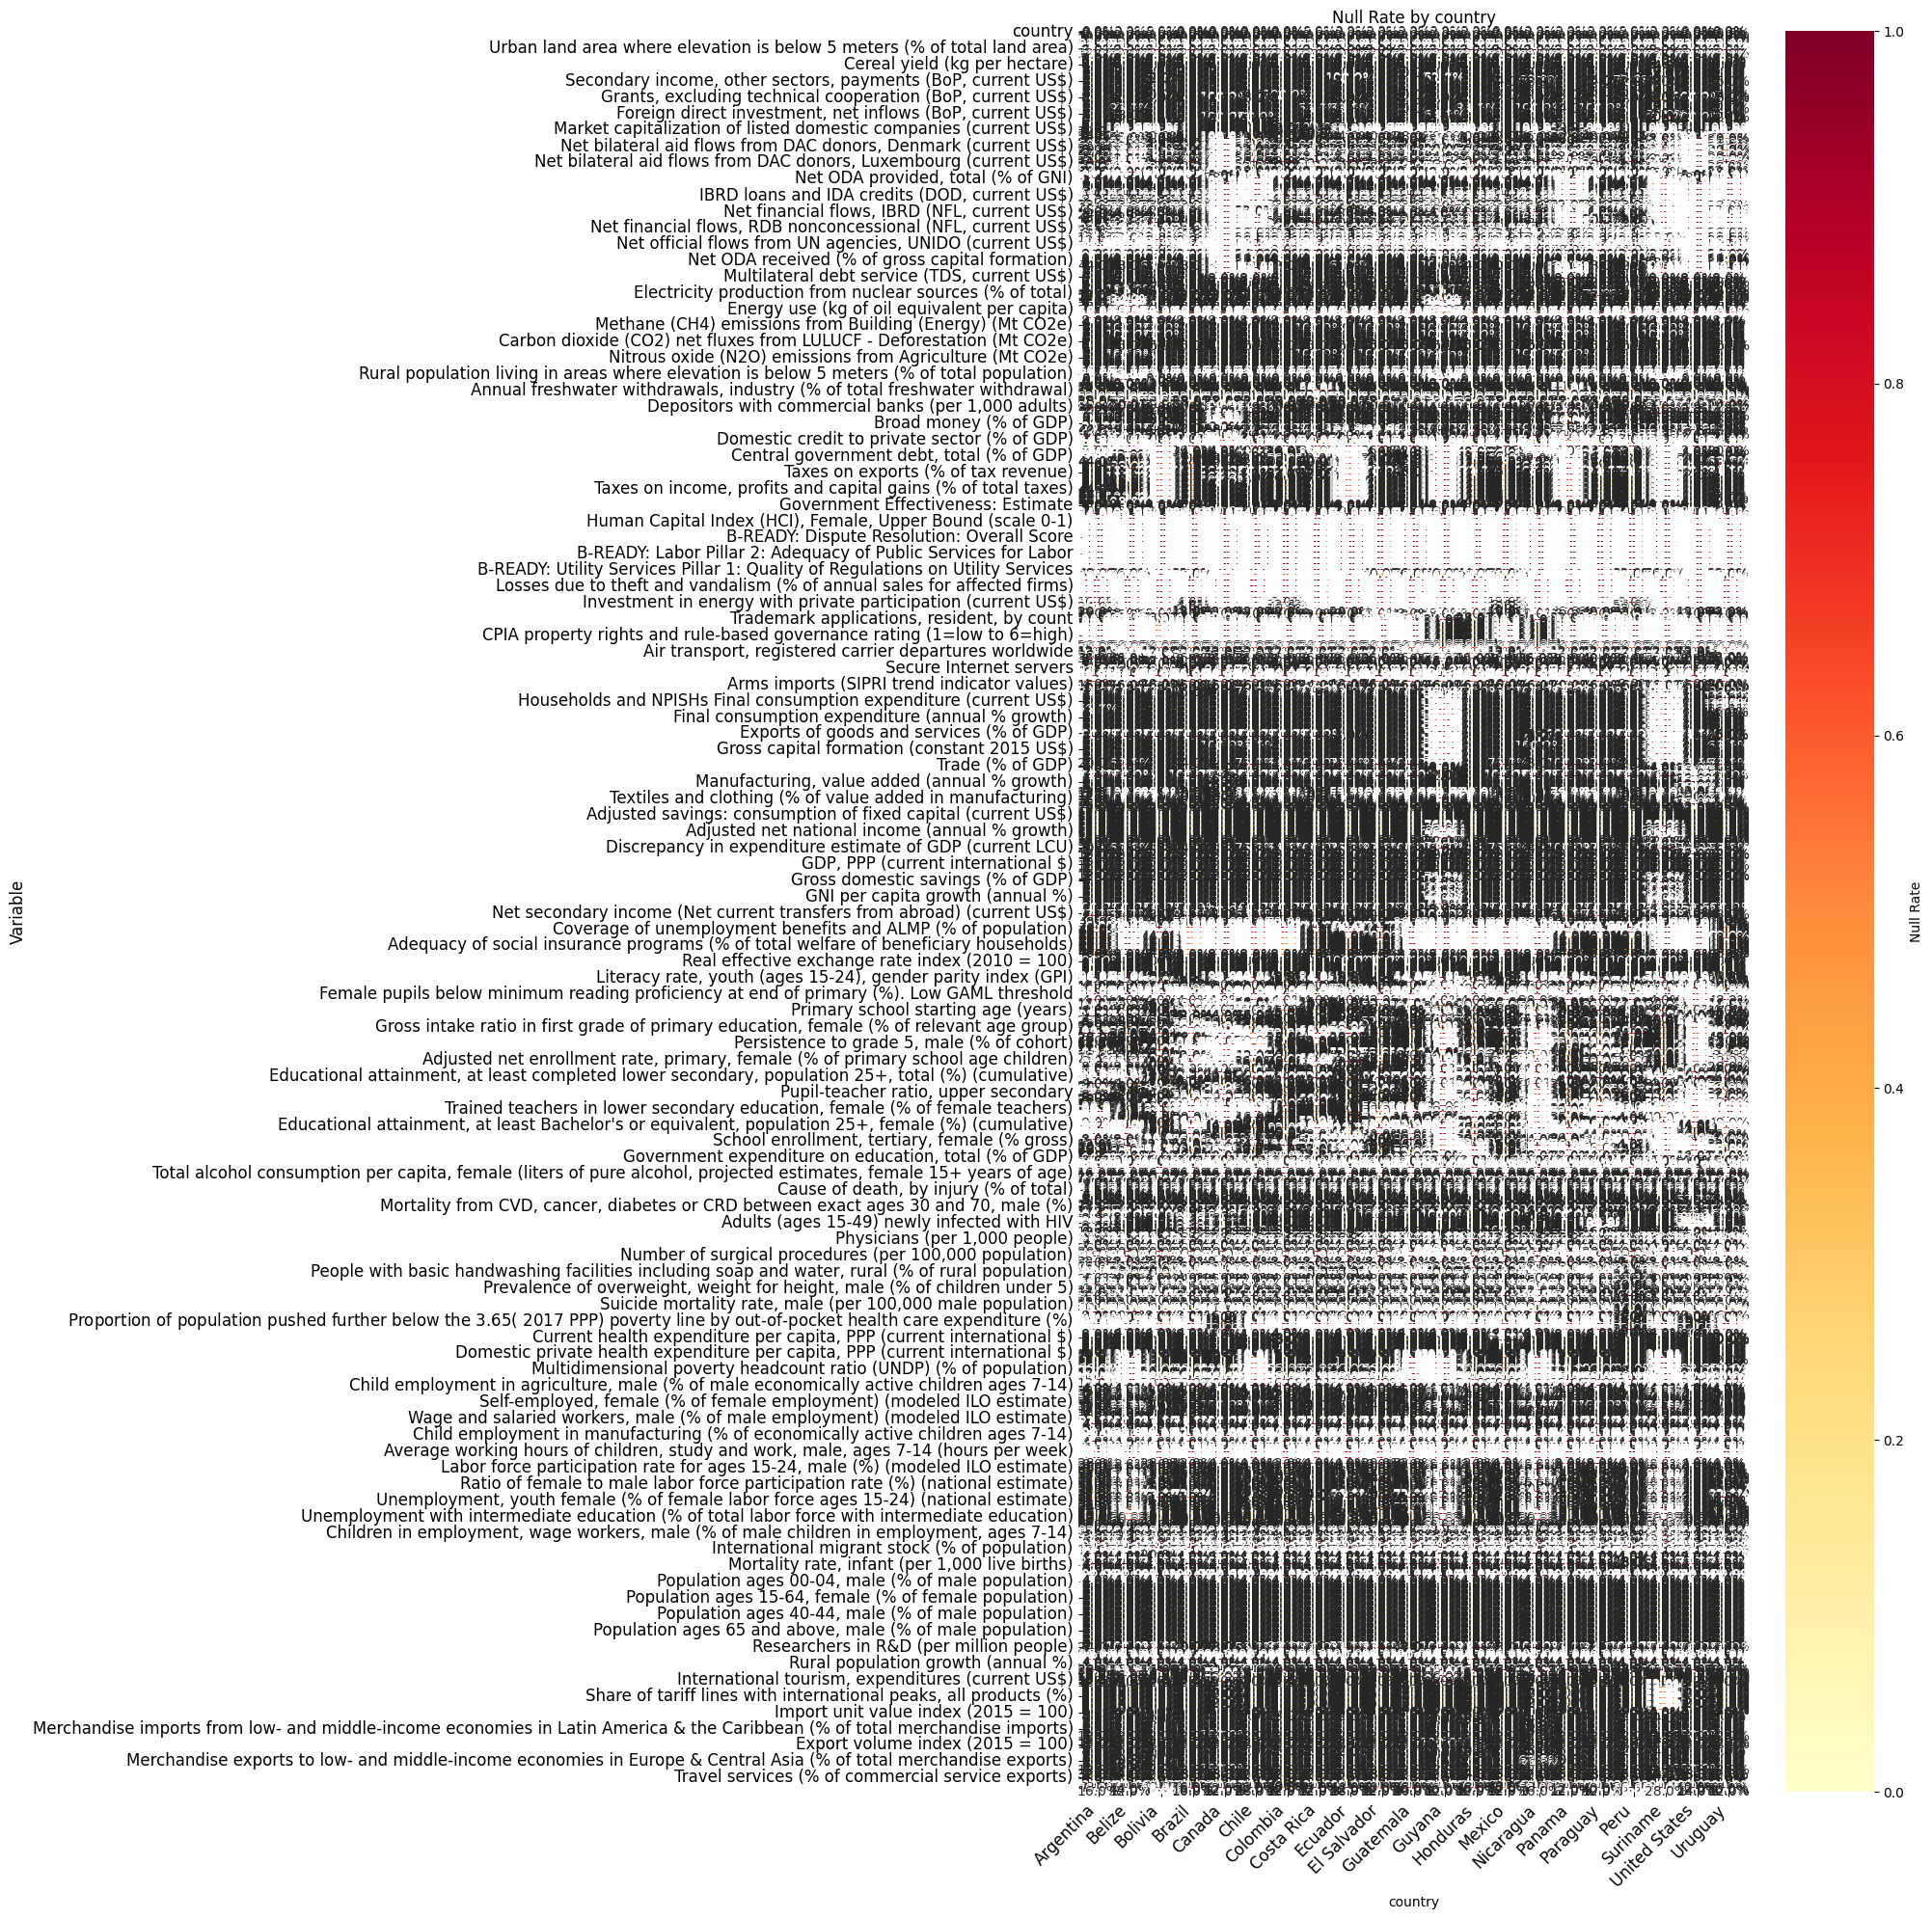

In [14]:
mull_heat_map(df,'country')

It is possible to see that the some indicators are not good, since most of its values are null

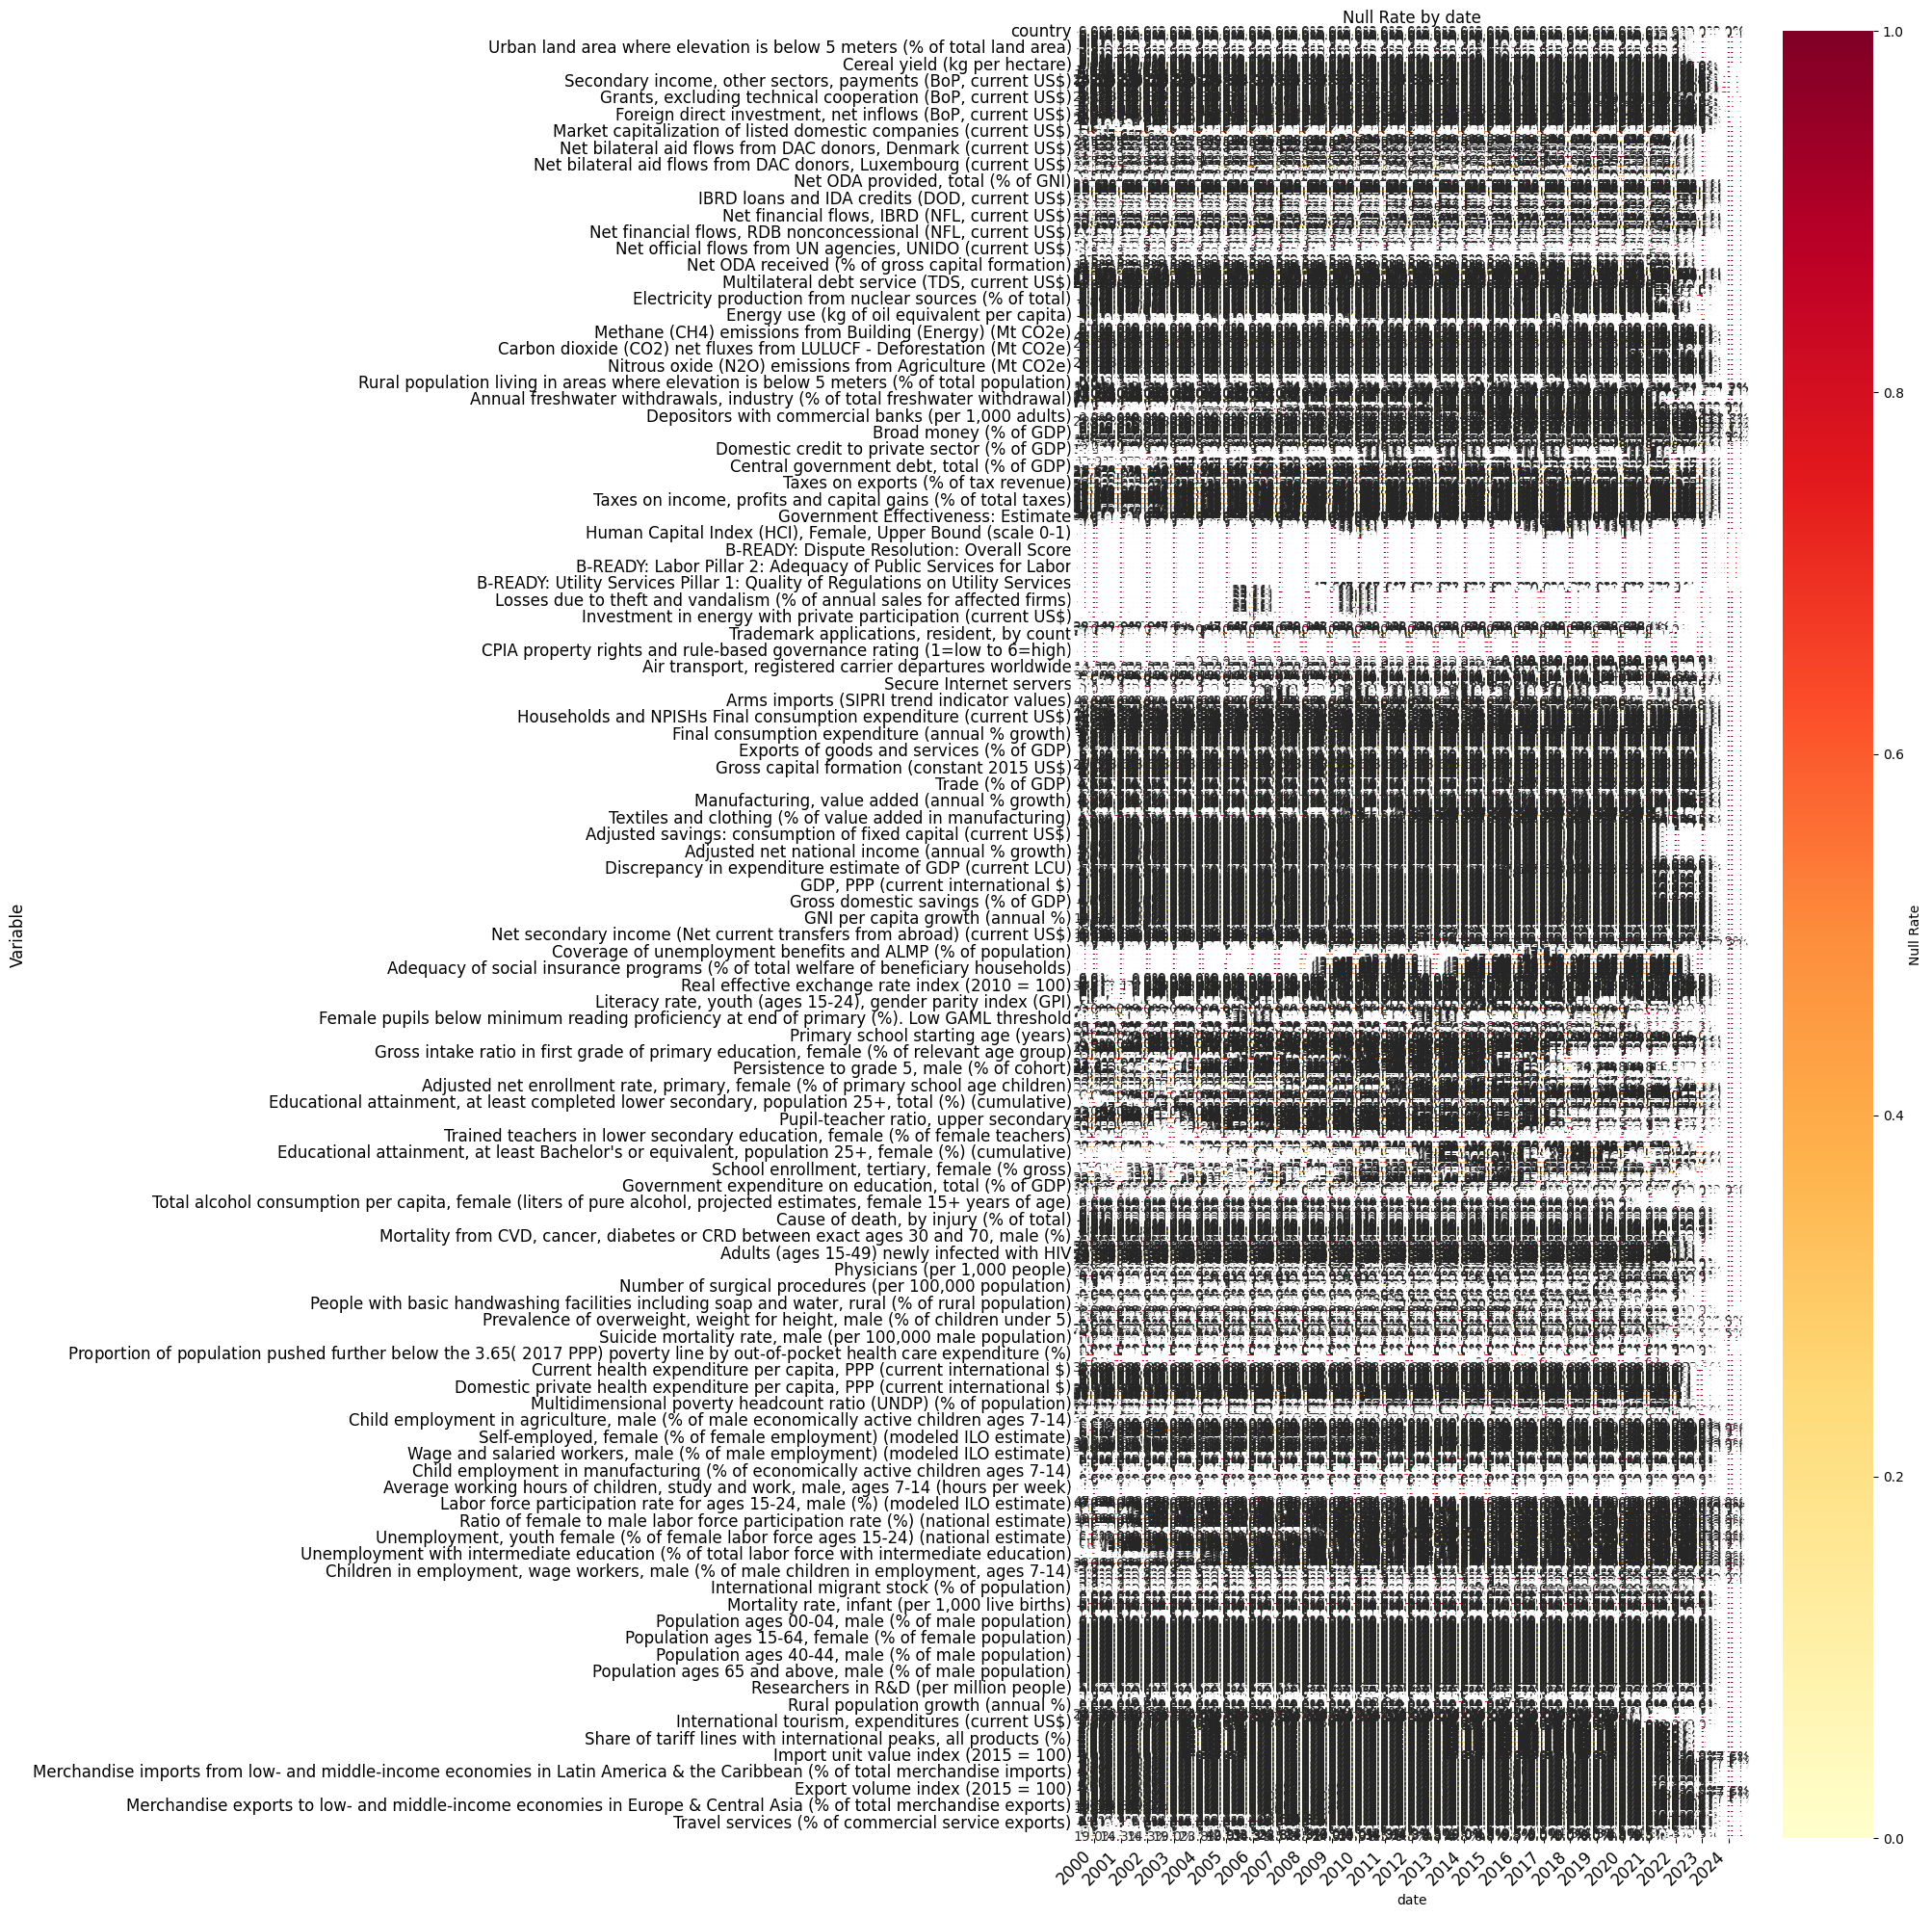

In [15]:
mull_heat_map(df,'date')

For this heat maps, we can see that the international migran stock indicator is not a good  indicator for us, since in many years we dont have any values in it, so we need to change that, furthermore we can remove that 2024 year from our data ser, for the same reason. 

In [16]:
threshold = 0.4  # % of missingness

df = df[df.date < '2024-01-01'] # to remove 2024 from the data set

null_rates_country = df.groupby(['country']).apply(lambda x: x.isnull().mean()).drop(columns = ['country'] ).reset_index()

columns_not_to_keep = []

for country in null_rates_country['country'].unique():
    country_data = null_rates_country[null_rates_country['country'] == country]
    
    for column in null_rates_country.columns[2:]:  # Skip 'country' and 'date'
        null_rate = country_data[column].values[0]  # Get the actual value (assumed to be a float)
        
        if null_rate > threshold:
            if column not in columns_not_to_keep:
                columns_not_to_keep.append(column)


In [17]:
columns_to_keep = [col for col in df.columns if col not in columns_not_to_keep]

print(f'Columns that have been dropped {columns_not_to_keep}')
print(f'Quantity of indicators dropped {len(columns_not_to_keep)} \nQuantity of keeped indicators {len(columns_to_keep)}')
df_filtered = df[columns_to_keep]

Columns that have been dropped ['Rural land area where elevation is below 5 meters (sq. km)', 'Rural land area where elevation is below 5 meters (% of total land area)', 'Urban land area where elevation is below 5 meters (sq. km)', 'Urban land area where elevation is below 5 meters (% of total land area)', 'Land area where elevation is below 5 meters (% of total land area)', 'Agricultural irrigated land (% of total agricultural land)', 'Rural land area (sq. km)', 'Urban land area (sq. km)', 'Net bilateral aid flows from DAC donors, Denmark (current US$)', 'Net bilateral aid flows from DAC donors, Estonia (current US$)', 'Net bilateral aid flows from DAC donors, Hungary (current US$)', 'Net bilateral aid flows from DAC donors, Iceland (current US$)', 'Net bilateral aid flows from DAC donors, Lithuania (current US$)', 'Net bilateral aid flows from DAC donors, Slovak Republic (current US$)', 'Net bilateral aid flows from DAC donors, Slovenia (current US$)', 'Net ODA provided, to the least

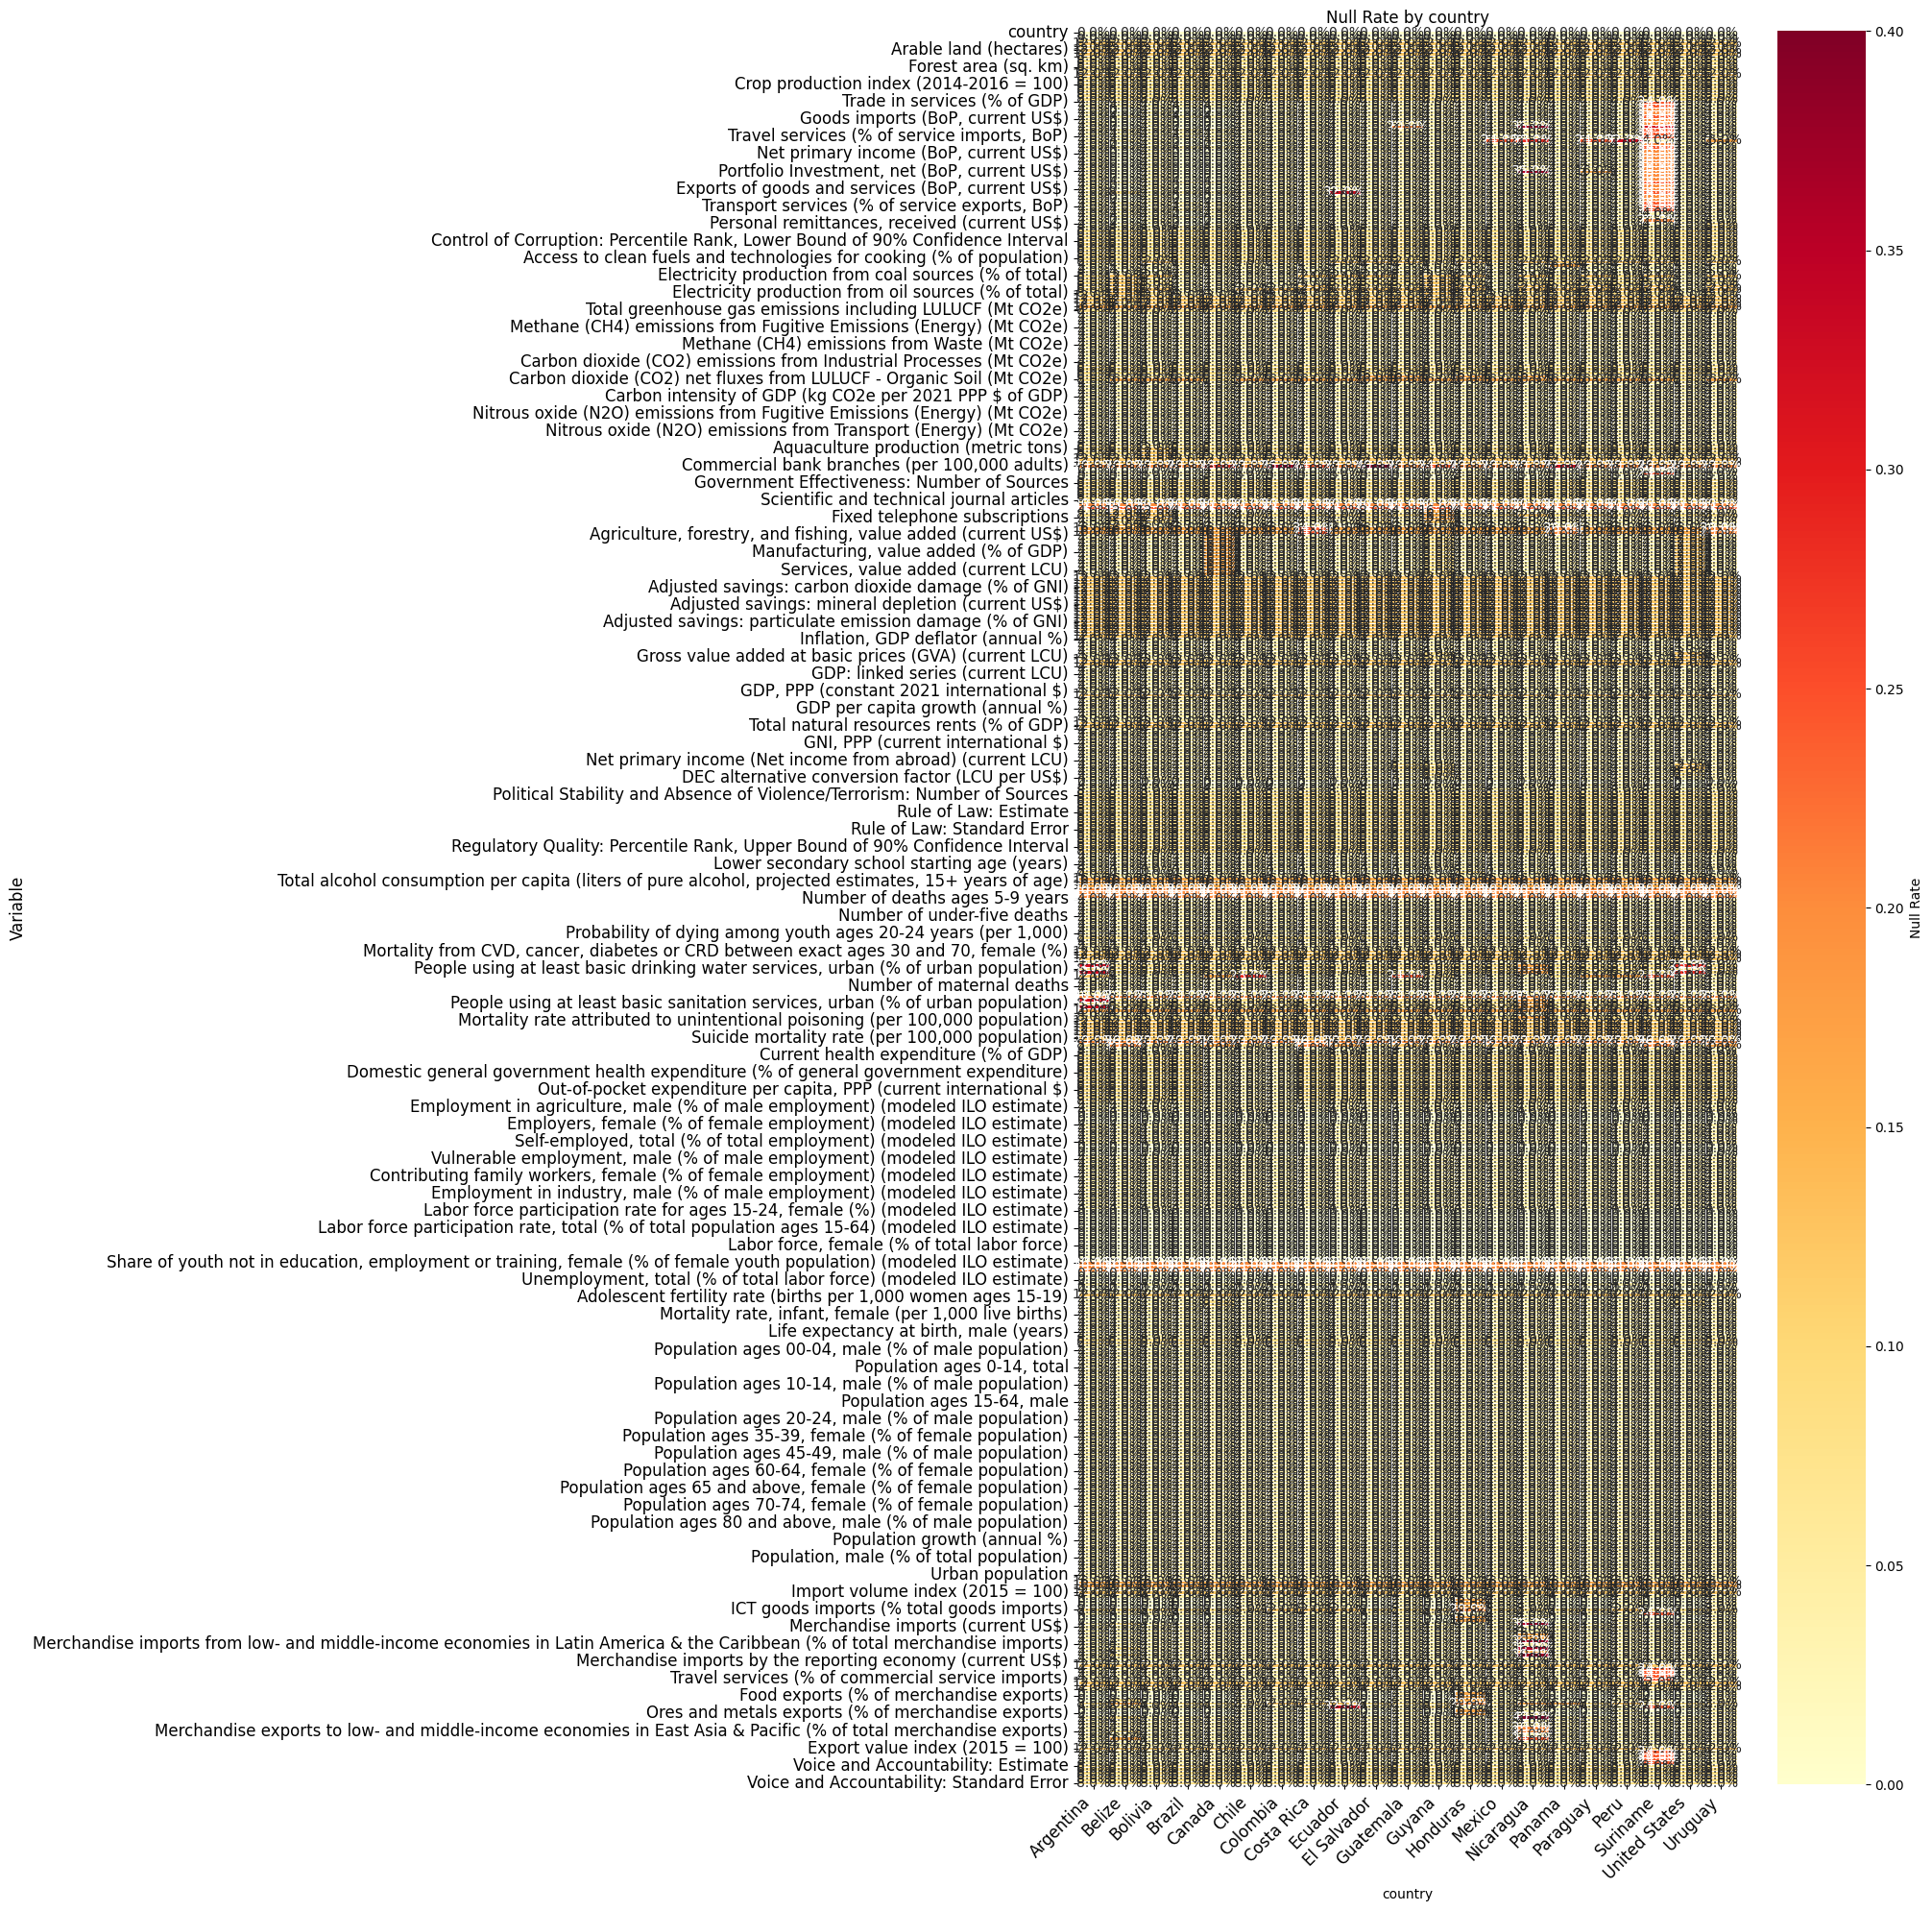

In [18]:
mull_heat_map(df_filtered,'country')

In [19]:

def plot_indicator_by_country(df, indicator_name):
    """
    Plots the given indicator over time for each country in the DataFrame,
    with both a legend and the country name displayed at the end of each line.

    Parameters:
    - df: DataFrame containing 'country', 'date', and indicator columns
    - indicator_name: str, the name of the indicator to plot
    """
    plt.figure(figsize=(15, 5))

    for country in df['country'].unique():
        country_data = df[df['country'] == country]
        if indicator_name in country_data.columns and not country_data[indicator_name].isna().all():
            plt.plot(country_data['date'], country_data[indicator_name], label=country)
            # Add country name at the end of the line
            last_valid_index = country_data[indicator_name].last_valid_index()
            if last_valid_index is not None:
                x = country_data.loc[last_valid_index, 'date']
                y = country_data.loc[last_valid_index, indicator_name]
                plt.text(x, y, f' {country}', fontsize=8, ha='left', va='center')

    plt.title(indicator_name)
    plt.xlabel('Year')
    plt.ylabel(indicator_name)
    plt.legend(title='Countries', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


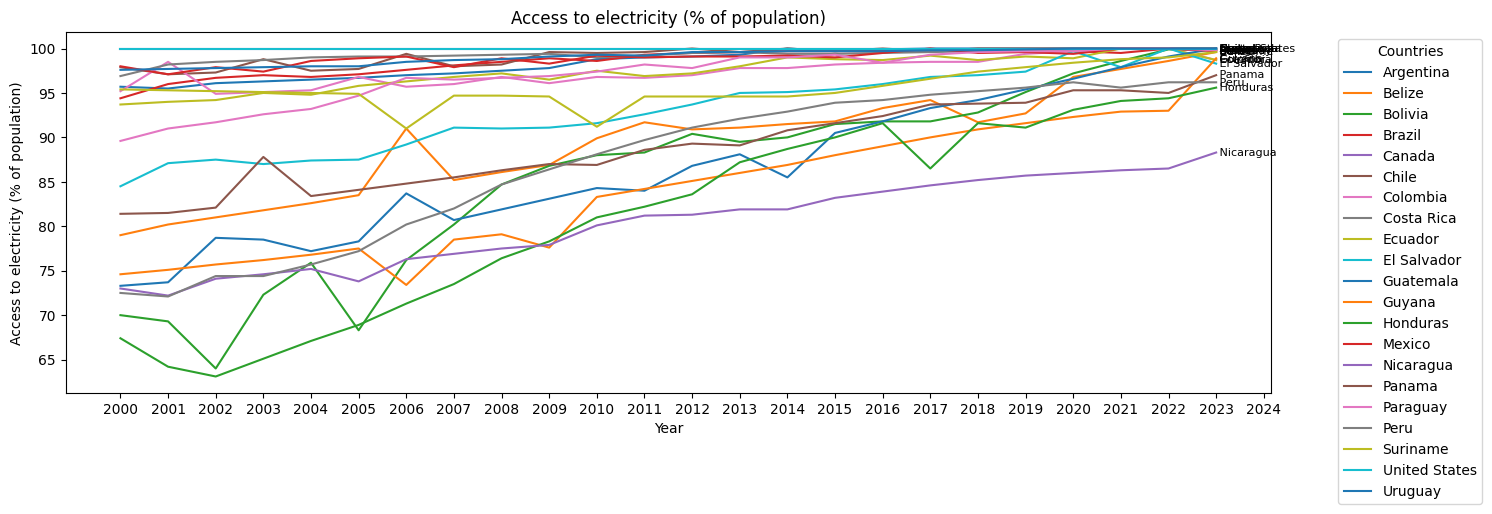

In [20]:
plot_indicator_by_country(df_filtered,'Access to electricity (% of population)')

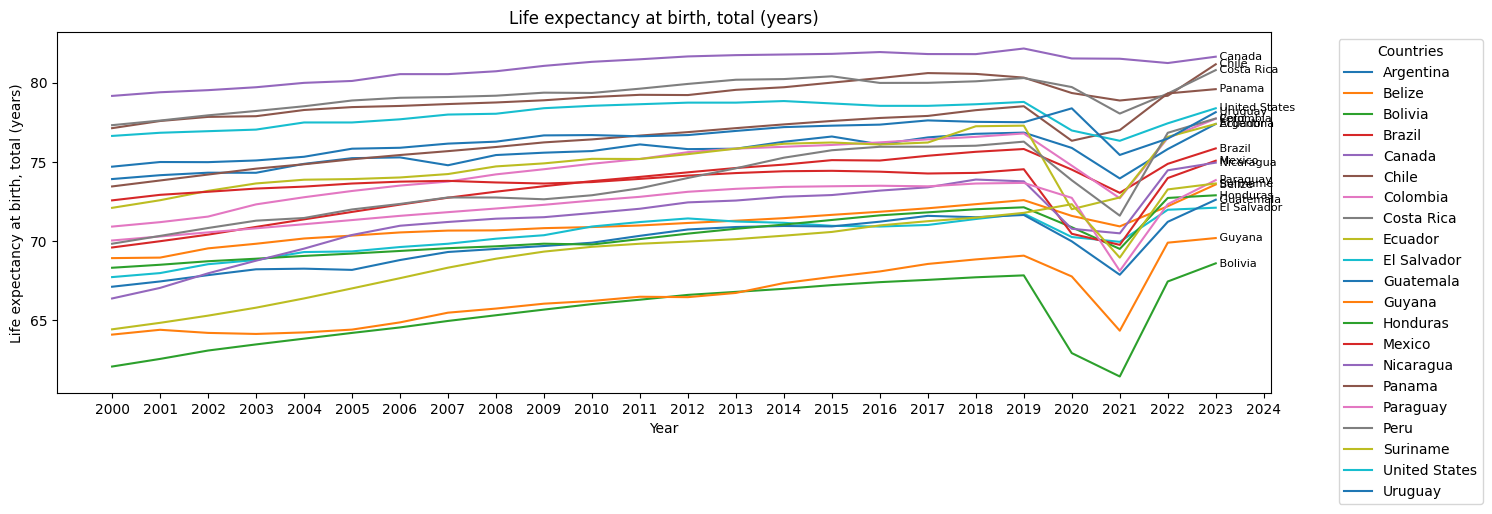

In [21]:
plot_indicator_by_country(df_filtered,'Life expectancy at birth, total (years)')

In [22]:
def imput_indicators_lr(df, country_col='country', year_col='date'):
    """
    Imputation using Lr
    
    Assumes:
    1. All indicator columns are numeric
    2. Year column is numeric
    3. Each country-indicator combo has ≥2 data points
    """
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
    # Get indicator columns (exclude metadata)
    indicators = [col for col in df.columns 
                 if col not in {country_col, year_col}]
    
    # Single-pass imputation
    def impute_group(group):
        for col in indicators:
            # Get known values
            known = group[group[col].notna()]
            X = known[[year_col]]
            y = known[col]
            
            # Train and predict (no length checks needed)
            model = LinearRegression().fit(X, y)
            missing = group[col].isna()
            if missing.any():
                group.loc[missing, col] = model.predict(group.loc[missing, [year_col]])
        return group
    
    return df.groupby(country_col, group_keys=False).apply(impute_group)

In [23]:
df_filtered_imputed = imput_indicators_lr(df_filtered)


In [24]:
df_filtered_imputed.head()

country  date  \
0  Argentina  2000   
1  Argentina  2001   
2  Argentina  2002   
3  Argentina  2003   
4  Argentina  2004   

   Fertilizer consumption (kilograms per hectare of arable land)  \
0                                          31.222250               
1                                          31.067217               
2                                          30.233939               
3                                          40.240779               
4                                          43.856402               

   Agricultural land (sq. km)  Agricultural land (% of land area)  \
0                   1285100.0                           46.958187   
1                   1286060.0                           46.993266   
2                   1287100.0                           47.031268   
3                   1291033.0                           47.174981   
4                   1294966.0                           47.318695   

   Arable land (hectares)  Arable land (hectares per person)  \
0              27640000.0                           0.742732   
1              27746000.0                           0.737439   
2              27862000.0                           0.732645   
3              29828200.0                           0.776285   
4              31794400.0                           0.819107   

   Arable land (% of land area)  Land under cereal production (hectares)  \
0                     10.099792                               10972298.0   
1                     10.138525                               10785378.0   
2                     10.180912                               10702110.0   
3                     10.899371                                9814395.0   
4                     11.617830                                9345371.0   

   Permanent cropland (% of land area)  ...  \
0                             0.365405  ...   
1                             0.365405  ...   
2                             0.365405  ...   
3                             0.365405  ...   
4                             0.365405  ...   

   Computer, communications and other services (% of commercial service exports)  \
0                                          13.427948                               
1                                          18.856084                               
2                                          30.647143                               
3                                          31.150664                               
4                                          32.804710                               

   Commercial service exports (current US$)  \
0                              4.739520e+09   
1                              4.431053e+09   
2                              3.353200e+09   
3                              4.304820e+09   
4                              5.082380e+09   

   Transport services (% of commercial service exports)  \
0                                          24.913914      
1                                          21.428315      
2                                          23.545568      
3                                          22.231359      
4                                          23.189726      

   Travel services (% of commercial service exports)  \
0                                          61.265694   
1                                          59.620139   
2                                          45.780449   
3                                          46.586849   
4                                          43.970935   

   Voice and Accountability: Estimate  \
0                            0.418347   
1                            0.285554   
2                            0.260063   
3                            0.349125   
4                            0.362041   

   Voice and Accountability: Number of Sources  \
0                                     9.000000   
1                                    14.082171   
2                                    11.000000

In [25]:
df = df_filtered_imputed.copy()

# 1. Filter to the most recent year
target_year = df['date'].max()
df_latest = df[df['date'] == target_year].copy()

# 2. Select all numeric features (excluding 'country' and 'date') for PCA
features = [col for col in df_latest.columns if col not in ['country', 'date']]
X = df_latest[features].values

# 3. Apply StandardScaler to normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # This centers and scales the data

# 4. Perform PCA on the scaled data
pca = PCA()
X_pca = pca.fit_transform(X_scaled)  

# Explained variance
print("Explained variance per component:")
print(pca.explained_variance_ratio_)

Explained variance per component:
[3.42670902e-01 1.29369699e-01 9.34417554e-02 6.75333046e-02
 5.58197148e-02 4.58694931e-02 3.56452635e-02 3.30917710e-02
 2.83764712e-02 2.44158950e-02 2.26170930e-02 2.21532224e-02
 1.69019420e-02 1.56659317e-02 1.38685044e-02 1.22640098e-02
 1.16624959e-02 1.03827771e-02 9.34130518e-03 8.90844957e-03
 3.57606279e-33]


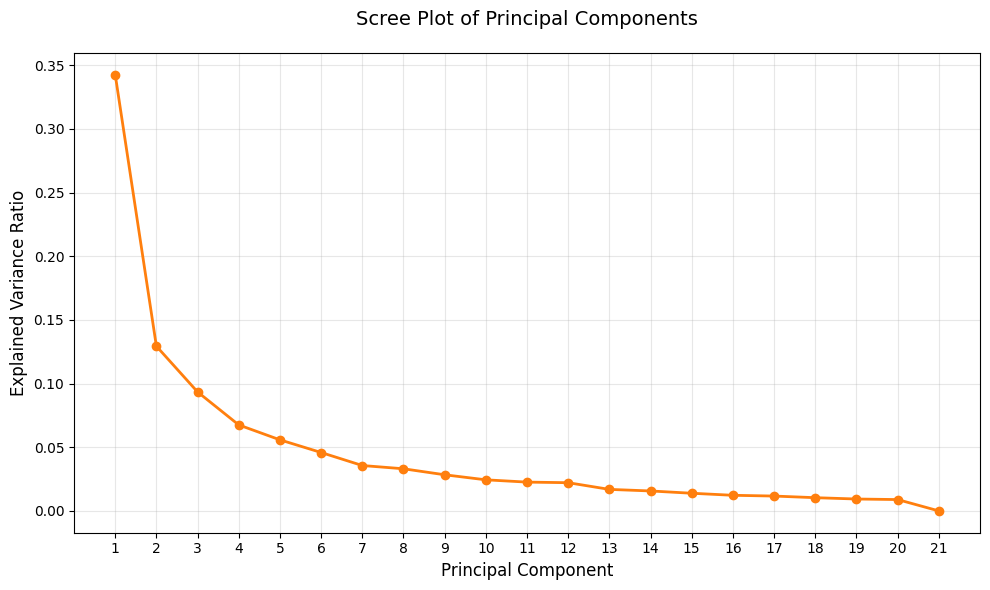

In [26]:
# Visualize the scree plot
plt.figure(figsize=(10, 6))
colors = plt.get_cmap('tab10')
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, 
         'o-', 
         linewidth=2, 
         color=colors(1))  # Use first color from tab10 palette
plt.title('Scree Plot of Principal Components', fontsize=14, pad=20)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(True, alpha=0.3)
plt.tight_layout() 
plt.show()

In [27]:

# 4. Determine number of components to explain 90% variance
explained = pca.explained_variance_ratio_.cumsum()
n_selected = (explained >= 0.9).argmax()+1
print(f"Selecting top {n_selected} PCA components explaining {explained[n_selected-1]:.2%} variance.")
X_selected = X_pca[:, :n_selected]


Selecting top 12 PCA components explaining 90.10% variance.


  File "h:\Python\Udacity\World_Bank_Data\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


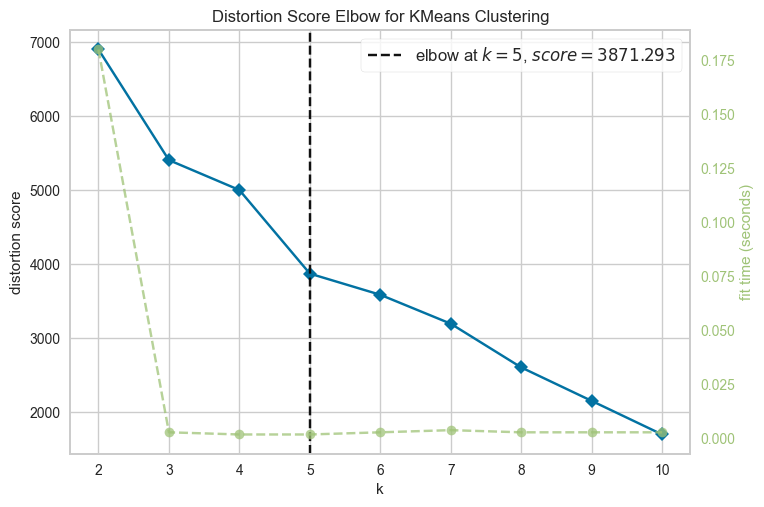

Best value using inertia 5


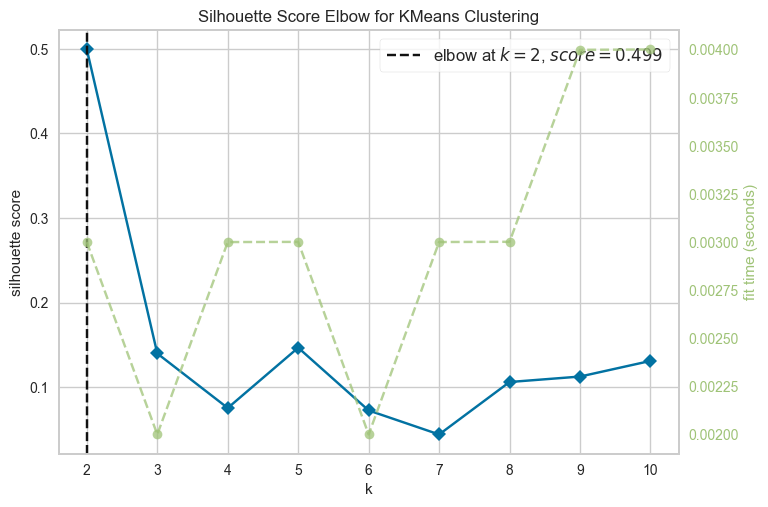

Best value using Silhouette 2


In [28]:
from yellowbrick.cluster import KElbowVisualizer

# Inertia (Elbow) Measures compactness (how close points are within clusters). Always decreases as K increases.
visualizer_inertia = KElbowVisualizer(KMeans(random_state=42), k=(2,11), metric='distortion')
visualizer_inertia.fit(X_selected)
visualizer_inertia.show()
print(f'Best value using inertia {visualizer_inertia.elbow_value_}')

# Silhouette - Silhouette measures quality of separation
visualizer_silhouette = KElbowVisualizer(KMeans(random_state=42), k=(2,11), metric='silhouette')
visualizer_silhouette.fit(X_selected)
visualizer_silhouette.show()
print(f'Best value using Silhouette {visualizer_silhouette.elbow_value_}')



I chose the Silhouette Score over the Elbow Method because it measures both cluster cohesion and separation, providing a clearer indication of cluster quality.
While the Elbow Method suggested 7 clusters based on inertia, the Silhouette Score indicated that 2 clusters were better separated and more meaningful.
To prioritize interpretability and stronger cluster distinction, I selected the number of clusters based on the Silhouette Score.

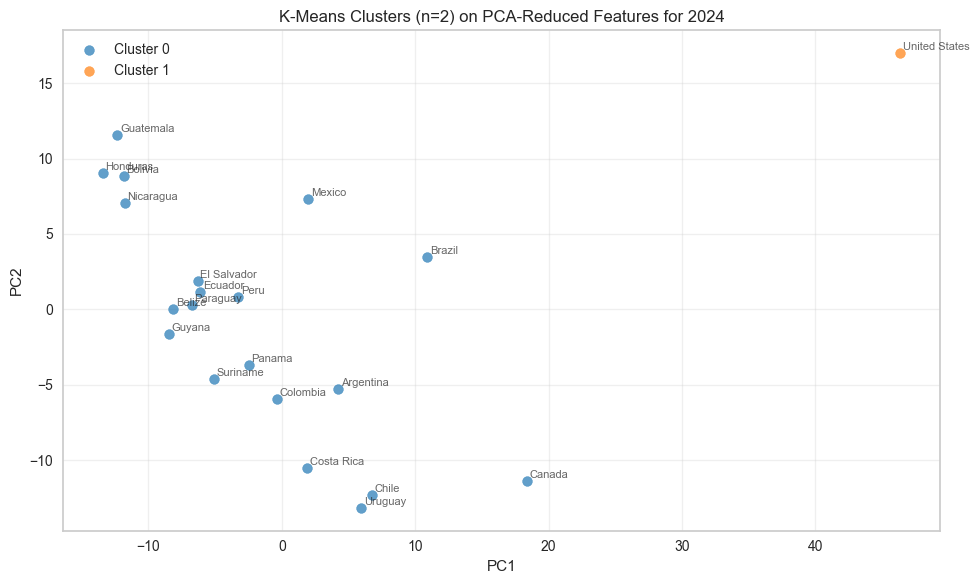

In [29]:

# 5. Apply K-Means clustering on the selected principal components
n_clusters = visualizer_silhouette.elbow_value_ # adjust as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_selected)
df_latest['cluster'] = cluster_labels

# 6. Visualize clusters in the space of the first two principal components
plt.figure(figsize=(10, 6))
colors = plt.get_cmap('tab10')
for label in range(n_clusters):
    mask = cluster_labels == label
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        s=50,
        alpha=0.7,
        color=colors(label),
        label=f'Cluster {label}'
    )
offset = 0.2
for i in range(X_pca.shape[0]):
    plt.text(
        X_pca[i, 0]+offset, X_pca[i, 1]+offset, 
        df_latest['country'].iloc[i],  
        fontsize=8,
        alpha=0.7
    )


plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'K-Means Clusters (n={n_clusters}) on PCA-Reduced Features for {target_year}')
plt.legend(loc='best')
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()


The United States is far from all other countries, even within Cluster 0, followed by Canada. This indicates that these countries have very distinct features compared to the others. This fact suggests that the United States and Canada has stronger indicators relative to other countries as expected.

Cluster 0 appears to represent higher-performing or more developed nations, while Cluster 1 groups less developed or similarly smaller economies closer together.

Since we used a small number of clusters, it is expected that our clustering results in good separation between clusters and interpretability.